## Setting up Functions

In [ ]:
#Setting up some helper functions for later
def divide_mat(A, b):
    C = A / b
    return C

def mult_mat(A, b):
    C = A * b
    return C

def substr_mat(A, b):
    b = np.reshape(b, (1, -1))
    return A - b

In [ ]:
# Building our transition matrix (using slide 4 in markov powerpoint). This contains the relative probabilites of going from one state to another and staying in same state etc.
def transition(pm):
    fm = np.zeros((4, 4))
    fm[0, 0] = pm[0]
    fm[1, 0] = 1 - pm[0]
    fm[0, 2] = pm[0]
    fm[1, 2] = 1 - pm[0]
    fm[2, 1] = 1 - pm[1]
    fm[3, 1] = pm[1]
    fm[2, 3] = 1 - pm[1]
    fm[3, 3] = pm[1]
    
    return fm

# Defining our objective function: does the constants (mu terms), transition matrix and AR residuals
def ofn(th, y, n, nk, capt, captst, skif):
    # Convert parameter vector to convenient form
    mu = th[:2]
    phi = np.array([1, -th[2]])
    sig = (th[3] * np.ones(n)) ** 2
    p = th[4] ** 2 / (1 + th[4] ** 2)
    q = th[5] ** 2 / (1 + th[5] ** 2)
    pm = np.array([p, q])

    # Calculate constants for AR residuals
    con1 = mu[0] + mu[0] * phi[1]
    con2 = mu[1] + mu[0] * phi[1]
    con3 = mu[0] + mu[1] * phi[1]
    con4 = mu[1] + mu[1] * phi[1]
    const = np.array([con1, con2, con3, con4])

    # Convert data to AR residuals
    eta = y[nk-1:capt]
    eta = np.column_stack((eta, y[nk-2:capt-1]))

    #(FIXED). Fixed an error where we were getting more than 2 cols, which made the matrix multiplication not work. Now cols of eta = 2
    #print("eta shape:", eta.shape)
    #print("phi shape:", phi.shape)

    eta_residuals = eta @ phi
    eta_residuals = np.tile(eta_residuals[:, np.newaxis], (1, 4))
    eta = divide_mat((substr_mat(eta_residuals, const) ** 2), sig)
    eta = mult_mat(np.exp(-eta / 2), 1 / np.sqrt(sig))

    # Compute probability transition matrix
    fm = transition(pm) 

    # Compute auxiliary variables for filtering
    ap = np.vstack((np.eye(n) - fm, np.ones((1, n))))
    chsi = np.sum(np.linalg.inv(ap.T @ ap), axis=1)

    # Here we update state probabilities iteratively using Hamilton filter
    f = 0
    for it in range(captst):
        fx = chsi * eta[it]
        fit = np.sum(fx)
        if fit == 0:
            continue  # Skip the iteration to avoid division by zero

        skif[it] = fx / fit
        f += np.log(fit)
        chsi = (fm @ fx / fit)
        
    return -f #return neg log lik

## Loading and Preprocessing Data

In [ ]:
data_hw5_with_date = pd.read_csv('/Users/kai/Documents/BSE/Term 3/Advanced Time Series – Nowcasting & Forecasting/Homework 2/series-230624.csv', header=None)
data_hw5_with_date = data_hw5_with_date.rename(columns={0: 'Date', 1: 'GDP'})
data_hw5 = data_hw5_with_date['GDP']
data_hw5 = data_hw5[0:250]

# Defining Variables

In [ ]:
#nth = 6
n = 4 #dimensions of the state vector
mu1=1
mu2=-mu1
phi1=3
sig = np.cov(data_hw5) * 0.75
lB_sig = np.min((data_hw5 - np.mean(data_hw5))**2)
uB_sig = np.max((data_hw5 - np.mean(data_hw5))**2)
p11 = 0.9
p22 = 0.7
nk  = 2 # First observation for likelihood evaluation

#sample size
capt = len(data_hw5)
skif = np.zeros((capt, 4)) # Initialise skif as a zero matrix with dimensions (T, 4)
captst = capt - nk + 1 # Effective sample size

#Putting parameters into an array
th = np.array([mu1, mu2, phi1, sig, p11, p22]) #theta (param vect)

## Optimising 

In [ ]:
result = minimize(ofn, th, args=(data_hw5, n, nk, capt, captst, skif), method='BFGS')

# Extract results
x = result.x
fval = result.fun
EXITFLAG = result.success
OUTPUT = result.message
GRAD = result.jac
HESSIAN = result.hess_inv

# Print results
print("Output Message:", OUTPUT)
print("Optimized Parameters:", x)
print("Function Value at Optimum:", fval)

Output Message: Optimization terminated successfully.
Optimized Parameters: [ 0.76056845 -0.76724989 -0.12013219  0.85275312  6.20811617  1.8355592 ]
Function Value at Optimum: 107.85229768440107


# Plotting GDP Growth and MS Model Probability Estimates

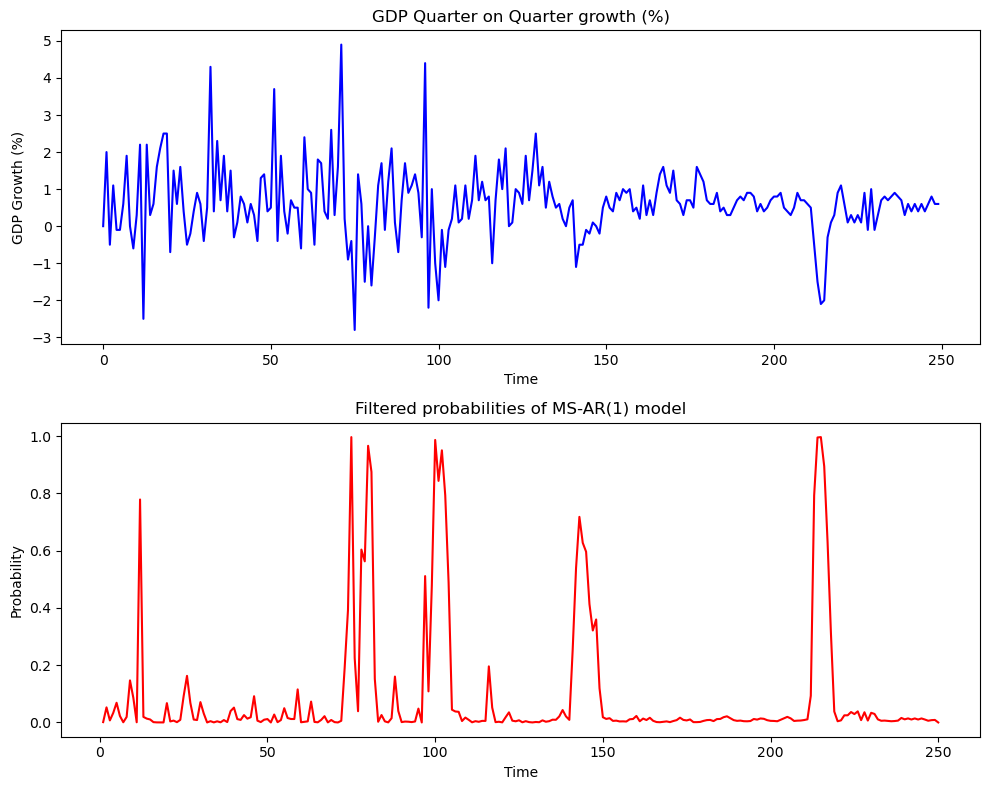

In [ ]:
probf = skif[:, 1] + skif[:, 3]
t = np.arange(1, len(probf) + 1)  # Adjust the range to match the length of probf

plt.figure(figsize=(10, 8))

# First plot for GDP
plt.subplot(2, 1, 1)
plt.plot(data_hw5[:len(t)], color='blue')  # Adjust to match the length of t if needed
plt.title('GDP Quarter on Quarter growth (%)')
plt.ylabel('GDP Growth (%)')
plt.xlabel('Time')

# Second plot for filtered probs
plt.subplot(2, 1, 2)
plt.plot(t, probf, color='red')
plt.title('Filtered probabilities of MS-AR(1) model')
plt.ylabel('Probability')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

In [ ]:
x = result.x
fval = result.fun
EXITFLAG = result.success
OUTPUT = result.message
GRAD = result.jac
HESSIAN = result.hess_inv

# Optimized Parameters
mu1, mu2, phi1, sig, p11, p22 = x

# Print results
print(f"Optimized Parameters:\n"
      f"Means for each state:\n{mu1:.4f}, {mu2:.4f}\n"
      f"Autoregressive coefficients:\n{phi1:.4f}\n"
      f"Variances:\n{sig ** 2:.4f}\n"
      f"Probabilities p11 p22:\n{p11:.4f}, {p22:.4f}\n"
      f"Value of log likelihood:\n{-fval:.4f}")


Optimized Parameters:
Means for each state:
0.7606, -0.7672
Autoregressive coefficients:
-0.1201
Variances:
0.7272
Probabilities p11 p22:
6.2081, 1.8356
Value of log likelihood:
-107.8523
